# Practice using pykep's `direct_pl2pl` UDP and pygmo

pykep doc: https://esa.github.io/pykep/documentation/trajopt.html#pykep.trajopt.direct_pl2pl

Yuri Shimane, 2022.04.21

In [92]:
import numpy as np
import pygmo as pg
import pykep as pk

%matplotlib notebook
%load_ext autoreload
%autoreload 2

### Launch epoch

First, a word on launch epoch. Pykep's UDPs usually want this in mjd2000. So we first create `pk.epoch` objects, which we then convert to floats. 

In [56]:
epoch1 = pk.epoch_from_string("2030-01-01 12:23:00.000")
epoch2 = pk.epoch_from_string("2032-01-01 12:23:00.000")
epoch1.mjd2000

10958.515972222222

In [57]:
# we construct our problem
prob = pk.trajopt.direct_pl2pl(
    p0 = "earth",
    pf = "mars",
    mass = 2000,   # kg
    thrust = 0.4,  # thrust in N
    isp = 3000,    # isp in seconds
    nseg = 30,     # number of segments in Sims-Flanagan transcription
    t0 = [epoch1.mjd2000, epoch2.mjd2000],  # Launch epochs bounds [mjd2000]
    tof = [150, 500],  # 
    vinf_dep = 2.0,   # Launch DV, km/s
    vinf_arr = 0.0,   # Arrival DV, km/s
)

In [58]:
class add_gradient:
    """Construct pygmo UDP with gradient
    https://esa.github.io/pygmo2/tutorials/coding_udp_constrained.html?highlight=add_gradient
    """
    def __init__(self, prob):
        self.prob = pg.problem(prob)

    def fitness(self, x):
        return self.prob.fitness(x)

    def get_bounds(self):
        return self.prob.get_bounds()

    def get_nec(self):
        return self.prob.get_nec()

    def get_nic(self):
        return self.prob.get_nic()

    def get_nobj(self):
        return self.prob.get_nobj()
        
    def gradient(self, x):
        return pg.estimate_gradient(lambda x: self.fitness(x), x) # we here use the low precision gradient

In [59]:
prob_with_gradient = add_gradient(prob)

In [76]:
# create ipopt algorithm class
uda = pg.ipopt() # pylint: disable=no-member
uda.set_integer_option("print_level", 5)
uda.set_integer_option("acceptable_iter", 4)
uda.set_integer_option("max_iter", 2000)      # probably need thousands of iterations

uda.set_numeric_option("tol", 1e-5)
uda.set_numeric_option("dual_inf_tol", 1e-6)
uda.set_numeric_option("constr_viol_tol", 1e-5)
uda.set_numeric_option("compl_inf_tol", 1e-6)

uda.set_numeric_option("acceptable_tol", 1e-3)
uda.set_numeric_option("acceptable_dual_inf_tol", 1e-2)
uda.set_numeric_option("acceptable_constr_viol_tol", 1e-6)
uda.set_numeric_option("acceptable_compl_inf_tol", 1e-6)

algo = pg.algorithm(uda)

In [77]:
algo

Algorithm name: Ipopt: Interior Point Optimization [deterministic]
	C++ class name: class pagmo::ipopt

	Thread safety: none

Extra info:
	Last optimisation return code: Solve_Succeeded (value = 0)
	Verbosity: 0
	Individual selection policy: best
	Individual replacement policy: best
	Integer options: {acceptable_iter : 4,  max_iter : 2000,  print_level : 5}
	Numeric options: {acceptable_compl_inf_tol : 1e-06,  acceptable_constr_viol_tol : 1e-06,  acceptable_dual_inf_tol : 0.01,  acceptable_tol : 0.001,  compl_inf_tol : 1e-06,  ...}

# Create a population

We now create a population. Here, we are not trying to do a thorough global search, so we initialize the population with `size=1`. This is equivalent to using the algorithm with a randomized initial guess, once. 
If we want to use an initial guess that we have a priori (say `x0`), then we should initialize the population with `size=0` then push back:

```python
# ... assume we have some initial guess vector x0 that we'd like to use
pop = pg.population(prob_with_gradient, size=0)   # initialize with size=0
pop.push_back(xopt)                               # now size is +1
```

In [78]:
pop = pg.population(prob_with_gradient, size=1)
pop

Problem name: <class '__main__.add_gradient'>
	C++ class name: class pybind11::object

	Global dimension:			99
	Integer dimension:			0
	Fitness dimension:			40
	Number of objectives:			1
	Equality constraints dimension:		7
	Inequality constraints dimension:	32
	Tolerances on constraints: [0, 0, 0, 0, 0, ... ]
	Lower bounds: [10958.5, 150, 200, -2000, -2000, ... ]
	Upper bounds: [11688.5, 500, 2000, 2000, 2000, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 3960
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1
	Gradient evaluations: 0

	Thread safety: none

Population size: 1

List of individuals: 
#0:
	ID:			8189446583477126148
	Decision vector:	[11000, 317.632, 1443.03, 25.0048, 1914.58, ... ]
	Fitness vector:		[-1443.03, 0.733619, -2.13605, -0.0656787, 1.49563, ... ]

Champion decision vector: [11000, 317.632, 1443.03, 25.0048, 1914.58, ... ]
Champion fitness: [-14

**CAVEAT**: when running with Jupyter notebooks, the algorithm iteration messages are shown on the shell session running Jupyter notebook, not on the notebook `Out` cell itself...

In [79]:
# solving with ipopt
pop = algo.evolve(pop)

In [86]:
algo

Algorithm name: Ipopt: Interior Point Optimization [deterministic]
	C++ class name: class pagmo::ipopt

	Thread safety: none

Extra info:
	Last optimisation return code: Maximum_Iterations_Exceeded (value = -1)
	Verbosity: 0
	Individual selection policy: best
	Individual replacement policy: best
	Integer options: {acceptable_iter : 4,  max_iter : 2000,  print_level : 5}
	Numeric options: {acceptable_compl_inf_tol : 1e-06,  acceptable_constr_viol_tol : 1e-06,  acceptable_dual_inf_tol : 0.01,  acceptable_tol : 0.001,  compl_inf_tol : 1e-06,  ...}

### Visualize result

See also: https://esa.github.io/pykep/documentation/trajopt.html#pykep.trajopt.direct_pl2pl

In [87]:
xopt, fopt = pop.champion_x, pop.champion_f

In [88]:
pop.champion_f

array([-1.85147692e+03,  9.85855299e-04, -3.56742190e-03,  9.78943474e-05,
        8.35018199e-04, -5.55726315e-03, -6.46677318e-04, -1.22433269e-01,
       -1.69430109e-01, -3.30311409e-01, -9.78499735e-01, -2.00901608e-02,
       -9.23659198e-01, -8.40497273e-01, -7.13347528e-01,  5.41547004e-01,
        3.20854858e-01, -9.77704807e-01, -9.66355593e-01, -1.90987162e-01,
        3.88908771e-02,  2.51169129e-02,  1.40228873e-02,  5.57415512e-03,
        1.20795217e-02,  1.37325825e-02, -7.59470501e-01, -9.21472402e-01,
        1.25496425e-01, -2.95842133e-01, -5.46958919e-01, -7.11680992e-01,
       -9.18332299e-01, -9.88133988e-01, -9.54573036e-01, -8.10788256e-01,
       -8.30606615e-01,  3.18883059e-02, -1.41376681e-03,  0.00000000e+00])

In [89]:
prob.pretty(xopt)


Low-thrust NEP transfer from earth to mars

Launch epoch: 11272.633801852911 MJD2000, a.k.a. 2030-Nov-11 15:12:40.480091
Arrival epoch: 11772.633801852911 MJD2000, a.k.a. 2032-Mar-25 15:12:40.480091
Time of flight (days): 500.0 

Launch DV (km/s) 1.6570480297958174 - [-1.0556949649827077,0.96957596899903,0.8314076943954462]
Arrival DV (km/s) 0.0 - [-0.0,-0.0,-0.0]

Spacecraft Initial Position (m)  : [97477225075.76064, 111511273057.72623, -7806051.435015484]
Spacecraft Initial Velocity (m/s): [-23968.098604031944, 20462.5769710864, 830.04313846964]
Spacecraft Initial Mass  (kg)    : 2000.0
Spacecraft Final Position (m)  : [127993562584.39764, 181199968965.3781, 660674908.1453073]
Spacecraft Final Velocity (m/s): [-18871.995964350936, 16044.531399185518, 798.8125852789021]
Spacecraft Final Mass  (kg)    : 1851.4769165047767


<IPython.core.display.Javascript object>


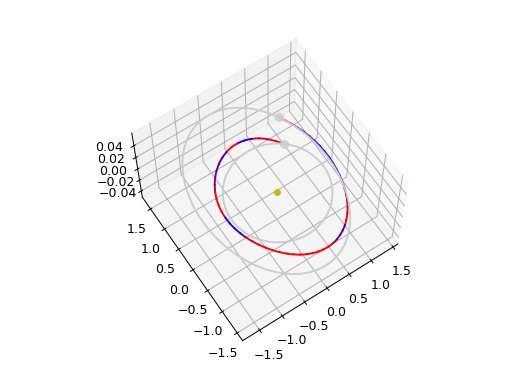

C:\Users\yshimane3\Miniconda3\envs\dev\lib\site-packages\pykep\trajopt\_direct.py:73: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')


<Axes3DSubplot:>

In [93]:
prob.plot_traj(xopt)

<AxesSubplot:xlabel='Time [days]', ylabel='Throttle [ND]'>

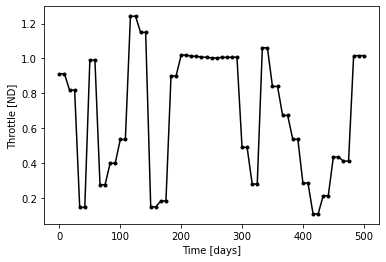

In [91]:
prob.plot_control(xopt)